In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import multiprocessing as mp
from pathlib import PurePath, Path
import pyarrow
import scipy.stats as stats
import time

In [2]:
# Code Snippets

# 2.4
def getTEvents(gRaw, h):
    tEvents, sPos, sNeg = [], 0, 0
    diff = gRaw.diff()
    for i in diff.index[1:]:
        sPos, sNeg = max(0, sPos+ + diff.loc[i]), min(0, sNeg + diff.loc[i])
        if sNeg < -h:
            sNeg = 0
            tEvents.append(i)
        elif sPos > h:
            sPos = 0
            tEvents.append(i)
    return pd.DatetimeIndex(tEvents)

# 3.1
def getDailyVol(close, span0=100):
    # daily vol, reindexed to close
    df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    df0 = pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:])
    df0 = close.loc[df0.index]/close.loc[df0.values].values-1  # daily returns
    df0 = df0.ewm(span=span0).std()
    return df0


# 3.2
def applyPtSlOnT1(close, events, ptSl, molecule):
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)
    if ptSl[0] > 0:
        pt = ptSl[0]*events_['trgt']
    else:
        pt = pd.Series(index=events.index)  # NaNs
    if ptSl[1] > 0:
        sl = -ptSl[1]*events_['trgt']
    else:
        sl = pd.Series(index=events.index)  # NaNs
    for loc, t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0 = close[loc:t1]  # path prices
        df0 = (df0/close[loc]-1)*events_.at[loc, 'side']  # path returns
        out.loc[loc, 'sl'] = df0[df0 < sl[loc]
                                 ].index.min()  # earliest stop loss
        out.loc[loc, 'pt'] = df0[df0 > pt[loc]
                                 ].index.min()  # earliest profit taking
    return out



# 3.6
def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads, t1=False, side=None):
    # 1) get target
    trgt = trgt.loc[tEvents]
    trgt = trgt[trgt > minRet]  # minRet
    # 2) get t1 (max holding period)
    if t1 is False:
        t1 = pd.Series(pd.NaT, index=tEvents)
    # 3) form events object, apply stop loss on t1
    if side is None:
        side_, ptSl_ = pd.Series(1., index=trgt.index), [ptSl[0], ptSl[0]]
    else:
        side_, ptSl_ = side.loc[trgt.index], ptSl[:2]
    events = (pd.concat({'t1': t1, 'trgt': trgt,
                         'side': side_}, axis=1).dropna(subset=['trgt']))
    df0 = mpPandasObj(func=applyPtSlOnT1, pdObj=('molecule', events.index),
                      numThreads=numThreads, close=close, events=events,
                      ptSl=ptSl_)
    events['t1'] = df0.dropna(how='all').min(axis=1)  # pd.min ignores nan
    if side is None:
        events = events.drop('side', axis=1)
    return events



# 3.4
def addVerticalBarrier(tEvents, close, numDays=1):
    t1 = close.index.searchsorted(tEvents + pd.Timedelta(days=numDays))
    t1 = t1[t1 < close.shape[0]]
    t1 = (pd.Series(close.index[t1], index=tEvents[:t1.shape[0]]))  # NaNs at end
    return t1


# 3.7
def getBins(events, close):
    '''
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    '''
    # 1) prices aligned with events
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1'].values).drop_duplicates()
    px = close.reindex(px, method='bfill')
    # 2) create out object
    out = pd.DataFrame(index=events_.index)
    out['ret'] = px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    if 'side' in events_:
        out['ret'] *= events_['side']  # meta-labeling
    out['bin'] = np.sign(out['ret'])
    if 'side' in events_:
        out.loc[out['ret'] <= 0, 'bin'] = 0  # meta-labeling
    return out


# 3.8
def dropLabels(events, minPct=.05):
    # apply weights, drop labels with insufficient examples
    while True:
        df0 = events['bin'].value_counts(normalize=True)
        if df0.min() > minPct or df0.shape[0] < 3:
            break
        print('dropped label: ', df0.argmin(), df0.min())
        events = events[events['bin'] != df0.argmin()]
    return events



# 20.5
def linParts(numAtoms, numThreads):
    # partition of atoms with a single loop
    parts = np.linspace(0, numAtoms, min(numThreads, numAtoms)+1)
    parts = np.ceil(parts).astype(int)
    return parts


# 20.6 
def nestedParts(numAtoms, numThreads, upperTriang=False):
    # partition of atoms with an inner loop
    parts, numThreads_ = [0], min(numThreads, numAtoms)
    for num in range(numThreads_):
        part = 1+4*(parts[-1]**2+parts[-1]+numAtoms*(numAtoms+1.)/numThreads_)
        part = (-1+part**.5)/2.
        parts.append(part)
    parts = np.round(parts).astype(int)
    if upperTriang:  # the first rows are heaviest
        parts = np.cumsum(np.diff(parts)[::-1])
        parts = np.append(np.array([0]), parts)
    return parts


# 20.7
def mpPandasObj(func, pdObj, numThreads=24, mpBatches=1, linMols=True, **kargs):
    '''
    Parallelize jobs, return a DataFrame or Series
    + func: function to be parallelized. Returns a DataFrame
    + pdObj[0]: Name of argument used to pass the molecule
    + pdObj[1]: List of atoms that will be grouped into molecules
    + kargs: any other argument needed by func

    Example: df1=mpPandasObj(func,('molecule',df0.index),24,**kargs)
    '''
    # not sure what this if/else does
    # or what argList is?
#     if linMols:
#         parts = linParts(len(argList[1]), numThreads*mpBatches)
#     else:
#         parts = nestedParts(len(argList[1]), numThreads*mpBatches)
    if linMols:
        parts = linParts(len(pdObj[1]), numThreads*mpBatches)
    else:
        parts = nestedParts(len(pdObj[1]), numThreads*mpBatches)

    jobs = []
    for i in range(1, len(parts)):
        job = {pdObj[0]: pdObj[1][parts[i-1]:parts[i]], 'func': func}
        job.update(kargs)
        jobs.append(job)
    if numThreads == 1:
        out = processJobs_(jobs)
    else:
        out = processJobs(jobs, numThreads=numThreads)
    if isinstance(out[0], pd.DataFrame):
        df0 = pd.DataFrame()
    elif isinstance(out[0], pd.Series):
        df0 = pd.Series()
    else:
        return out
    for i in out:
        df0 = df0.append(i)
    df0 = df0.sort_index()
    return df0


# 20.8
def processJobs_(jobs):
    # Run jobs sequentially, for debugging
    out = []
    for job in jobs:
        out_ = expandCall(job)
        out.append(out_)
    return out


# 20.9
def reportProgress(jobNum, numJobs, time0, task):
    # Report progress as asynch jobs are completed
    msg = [float(jobNum)/numJobs, (time.time()-time0)/60.]
    msg.append(msg[1]*(1/msg[0]-1))
    timeStamp = str(dt.datetime.fromtimestamp(time.time()))
    msg = timeStamp+' '+str(round(msg[0]*100, 2))+'% '+task+' done after ' + \
        str(round(msg[1], 2))+' minutes. Remaining ' + \
        str(round(msg[2], 2))+' minutes.'
    if jobNum < numJobs:
        sys.stderr.write(msg+'\r')
    else:
        sys.stderr.write(msg+'\n')
    return


def processJobs(jobs, task=None, numThreads=24):
    # Run in parallel.
    # jobs must contain a 'func' callback, for expandCall
    if task is None:
        task = jobs[0]['func'].__name__
    pool = mp.Pool(processes=numThreads)
    outputs, out, time0 = pool.imap_unordered(
        expandCall, jobs), [], time.time()
    # Process asyn output, report progress
    for i, out_ in enumerate(outputs, 1):
        out.append(out_)
        reportProgress(i, len(jobs), time0, task)
    pool.close()
    pool.join()  # this is needed to prevent memory leaks
    return out


# 20.10
def expandCall(kargs):
    # Expand the arguments of a callback function, kargs['func']
    func = kargs['func']
    del kargs['func']
    out = func(**kargs)
    return out


In [3]:
# 3.1
# Load data
data_f = PurePath('data/clean_IVE_ticks.parq')
df = pd.read_parquet(data_f)
print(df)

                        price     bid     ask   size      v            dv
dates                                                                    
2009-09-28 09:30:00   50.7900   50.70   50.79    100    100  5.079000e+03
2009-09-28 09:30:00   50.7100   50.70   50.79    638    638  3.235298e+04
2009-09-28 09:31:32   50.7500   50.75   50.76    100    100  5.075000e+03
2009-09-28 09:31:33   50.7500   50.72   50.75    100    100  5.075000e+03
2009-09-28 09:31:50   50.7500   50.73   50.76    300    300  1.522500e+04
2009-09-28 09:31:51   50.7500   50.74   50.76    300    300  1.522500e+04
2009-09-28 09:32:06   50.7800   50.76   50.78    300    300  1.523400e+04
2009-09-28 09:32:06   50.7800   50.76   50.78    500    500  2.539000e+04
2009-09-28 09:32:06   50.7800   50.76   50.78    100    100  5.078000e+03
2009-09-28 09:32:56   50.8226   50.81   50.83    100    100  5.082260e+03
2009-09-28 09:33:02   50.8100   50.80   50.81    500    500  2.540500e+04
2009-09-28 09:33:02   50.8100   50.80 

In [4]:
# Create dollar bars

dol_col = df['dv']
dol = 0
dol_cutoff = 1_000_000
idx = []
for i, x in enumerate(dol_col):
    dol += x
    if dol >= dol_cutoff:
        idx.append(i)
        dol = 0
        
df_dol = df.iloc[idx].drop_duplicates().dropna()

In [5]:
close = df_dol.price.copy()
print(close.shape)

(58288,)


In [6]:
df_dol.loc['2018-08-13 10:26:32']

,price,bid,ask,size,v,dv
dates,,,,,,
2018-08-13 10:26:32,114.2,114.19,114.20,6300,6300,719460.0
2018-08-13 10:26:32,114.2,114.20,114.22,13258,13258,1514063.6


In [7]:
# Remove duplicate indexes
# e.g.:
# The date '2018-08-13 10:26:32' has two identical dollar bars
# since there was so much volume at this time (huge order?)
# with the same price of $114.2. Since this provides no
# extra info since it's same time and price, we can
# remove these
close = close[~close.index.duplicated()]

In [8]:
# getting standard deviation of daily returns
dailyVol = getDailyVol(close)

In [9]:
dailyVol

dates
2009-09-29 09:59:21         NaN
2009-09-29 10:04:46    0.005981
2009-09-29 10:31:39    0.004469
2009-09-29 10:52:23    0.004376
2009-09-29 11:34:53    0.004261
2009-09-29 12:00:17    0.004977
2009-09-29 12:34:54    0.004894
2009-09-29 13:30:07    0.004521
2009-09-29 14:18:35    0.004214
2009-09-29 15:09:13    0.003996
2009-09-29 15:34:28    0.003945
2009-09-29 15:53:15    0.004068
2009-09-30 09:32:03    0.004160
2009-09-30 09:44:47    0.005038
2009-09-30 09:56:31    0.006797
2009-09-30 10:06:07    0.007962
2009-09-30 10:37:22    0.008852
2009-09-30 11:28:56    0.008991
2009-09-30 11:57:40    0.008940
2009-09-30 12:48:14    0.008708
2009-09-30 13:21:56    0.008442
2009-09-30 14:20:57    0.008246
2009-09-30 14:49:59    0.008078
2009-09-30 15:05:38    0.008165
2009-09-30 15:42:01    0.008044
2009-09-30 15:58:56    0.007879
2009-10-01 09:30:07    0.007829
2009-10-01 09:39:37    0.008086
2009-10-01 09:52:26    0.008035
2009-10-01 10:00:15    0.007858
                         ...   
20

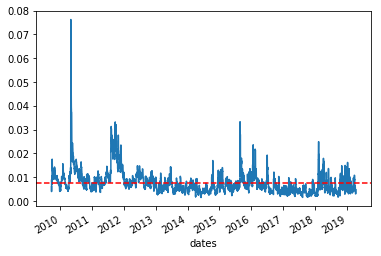

In [10]:
f,ax=plt.subplots()
dailyVol.plot(ax=ax)
ax.axhline(dailyVol.mean(),ls='--',color='r')

In [11]:
# using CUSUM (cumulative sum) filter
# to detect a shift in the mean value of daily vol
tEvents = getTEvents(close,h=dailyVol.mean())

In [12]:
tEvents

DatetimeIndex(['2009-09-28 09:53:49', '2009-09-28 10:02:52',
               '2009-09-28 10:10:21', '2009-09-28 10:19:36',
               '2009-09-28 10:24:23', '2009-09-28 10:34:30',
               '2009-09-28 10:45:25', '2009-09-28 11:10:57',
               '2009-09-28 11:24:29', '2009-09-28 11:37:06',
               ...
               '2019-04-09 13:51:59', '2019-04-09 14:35:19',
               '2019-04-09 14:50:54', '2019-04-09 15:14:26',
               '2019-04-09 15:28:09', '2019-04-09 15:38:53',
               '2019-04-09 15:54:00', '2019-04-09 15:59:08',
               '2019-04-09 15:59:58', '2019-04-09 16:00:00'],
              dtype='datetime64[ns]', length=53064, freq=None)

In [13]:
# 3.1b
# this is the expiration limit in our triple barrier method
# Definied as number of bars elapsed since position initiated
t1 = addVerticalBarrier(tEvents, close, 10)

In [14]:
# 3.1c
# Finding the time of the first barrier touch

minRet = 0.02
numThreads = 1  # multiple threads never end on windows
ptSl = [1, 1]
# ptSl = 1
events = getEvents(close, tEvents, ptSl, dailyVol, minRet, numThreads, t1=t1)

C:\Users\mlevy\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


In [15]:
# 3.1d
# Generate labels by which barrier we touch first
# 1 => Top horizonal barrier
# -1 => Bottom horizonal barrier

labels = getBins(events, close)
labels.bin.value_counts()

-1.0    694
 1.0    507
Name: bin, dtype: int64

In [16]:
# 3.2
# Drop observaations w/ extremely rare labels
clean_labels = dropLabels(labels)
clean_labels.bin.value_counts()

-1.0    694
 1.0    507
Name: bin, dtype: int64

In [17]:
# 3.3
# Modifying getBins to return a 0 when vertical barrier is touched first

def getBins_v2(events, close, t1=None):
    '''
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    -t1 is vertical barrier series
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    '''
    # 1) prices aligned with events
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1'].values).drop_duplicates()
    px = close.reindex(px, method='bfill')
    # 2) create out object
    out = pd.DataFrame(index=events_.index)
    out['ret'] = px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    if 'side' in events_:
        out['ret'] *= events_['side']  # meta-labeling
    out['bin'] = np.sign(out['ret'])
    if 'side' in events_:
        out.loc[out['ret'] <= 0, 'bin'] = 0  # meta-labeling
    # ADDED VERTICAL BARRIER CODE HERE
    elif t1 is not None:
        # Not applicable to meta-labeling
        # Finding all timestamps of hitting a barrier (endtime)
        # which is also in our vertical barrier series (t1)
        vertical_touches = events[events['t1'].isin(t1.values)].index
        out.loc[vertical_touches, 'bin'] = 0
    # END
    return out


In [18]:
labels_v2 = getBins_v2(events, close, t1)
labels_v2.bin.value_counts()

 0.0    473
-1.0    420
 1.0    308
Name: bin, dtype: int64

In [70]:
# 3.4
# Around 1000 bars per month, 48 per day
close['2018-01-01':'2018-12-31'].count()/12
ma_df = pd.DataFrame().assign(price=close).assign(ma_l=close.rolling(window=20).mean()).assign(ma_s=close.rolling(window=5).mean())
# ma_df = pd.DataFrame().assign(price=close).assign(ma_l=close.rolling(window=7).mean()).assign(ma_s=close.rolling(window=3).mean())

# SMAE(1000, 1%)
# similar to SMAE(30, 1%) on time chart
# ma_df = pd.DataFrame().assign(price=close).assign(ma=close.rolling(window=1000).mean())
# ma_df = ma_df.assign(low=ma_df.ma-ma_df.ma*0.01).assign(high=ma_df.ma+ma_df.ma*0.01)

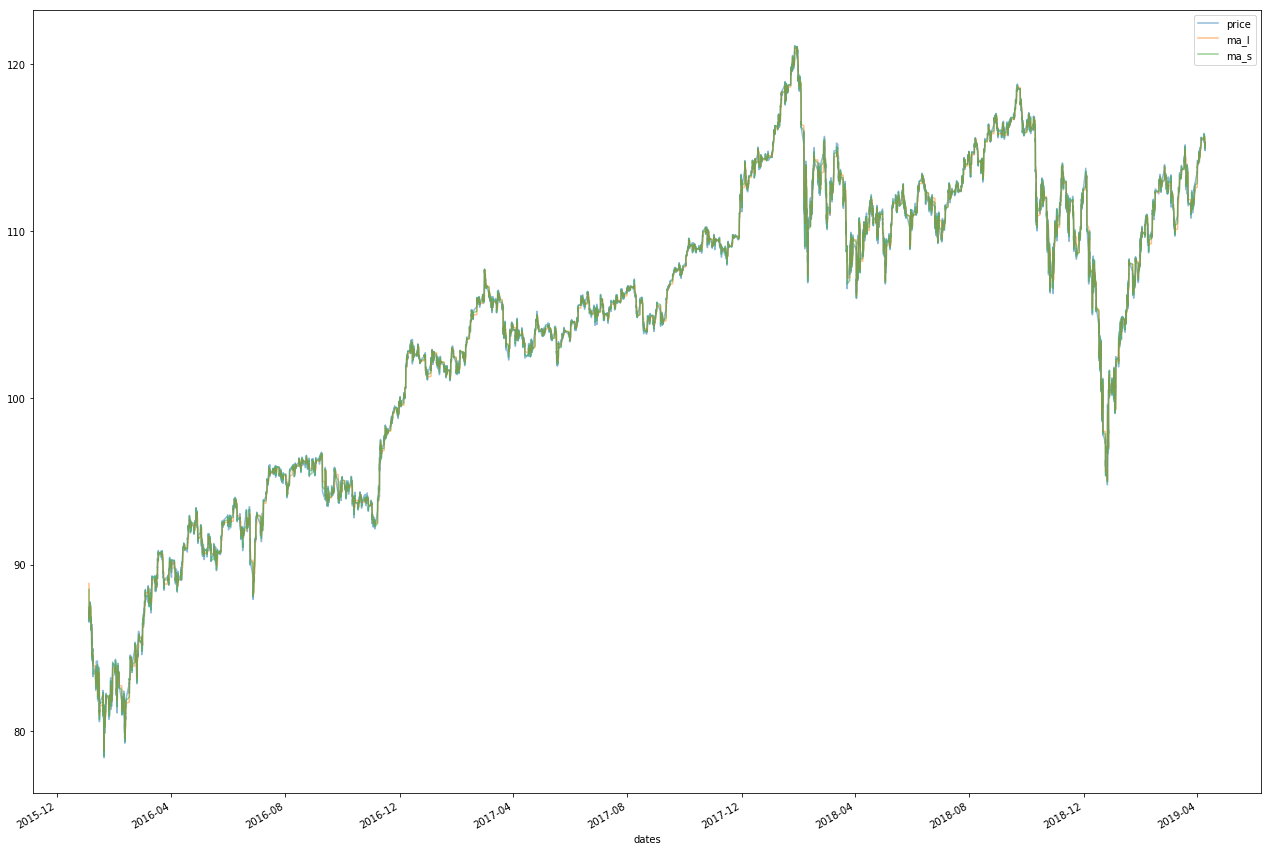

In [71]:
f, ax = plt.subplots(figsize=(22,16))
ma_df.loc['2016':].plot(ax=ax, alpha=.5)

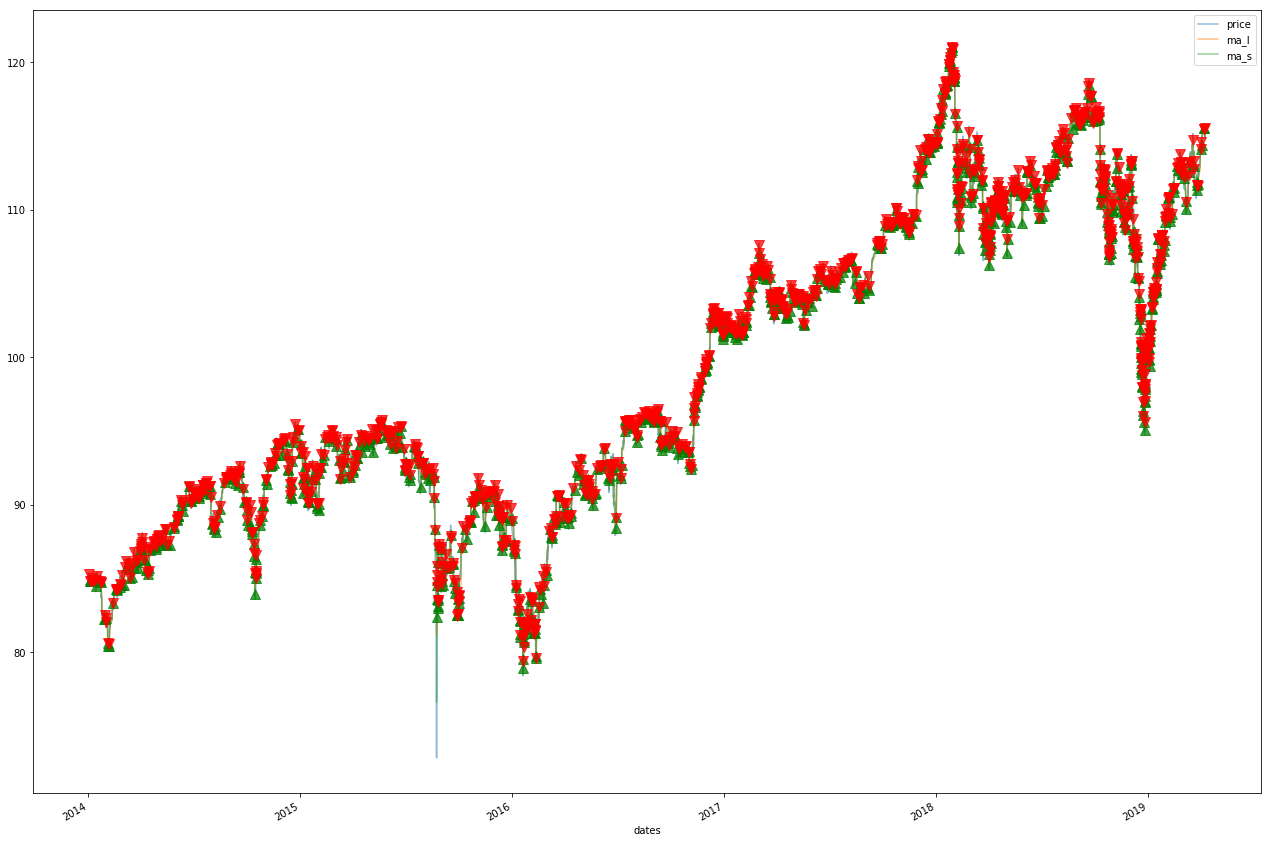

In [72]:
def buySignal(df):
    cross = df.ma_s > df.ma_l
    # Check if this is first time crossing
    first_cross = df.ma_s.shift(1) < df.ma_l.shift(1)
    return df.ma_s[cross & first_cross]

def sellSignal(df):
    cross = df.ma_s < df.ma_l
    first_cross = df.ma_s.shift(1) > df.ma_l.shift(1)
    return df.ma_s[cross & first_cross]
    
buy_sig = buySignal(ma_df)
sell_sig = sellSignal(ma_df)

f, ax = plt.subplots(figsize=(22,16))
ma_df.loc['2014':].plot(ax=ax, alpha=.5)
buy_sig.loc['2014':].plot(ax=ax,ls='',marker='^', markersize=10,
                     alpha=0.75, label='upcross', color='g')
sell_sig.loc['2014':].plot(ax=ax,ls='',marker='v', markersize=10, 
                       alpha=0.75, label='downcross', color='r')

In [73]:
long = pd.Series(1, index=buy_sig.index)
short = pd.Series(-1, index=sell_sig.index)
side = pd.concat([long, short]).sort_index()  # each time we switch sides

In [74]:
dailyVol = getDailyVol(ma_df.price)
tEvents = getTEvents(ma_df.price, h=dailyVol.mean())
t1 = addVerticalBarrier(tEvents, ma_df.price, 1)

minRet = 0.01
numThreads = 1
ptSl = [1, 2]
# Determine which barrier hit first
events = getEvents(ma_df.price, tEvents, ptSl, dailyVol, minRet, numThreads, t1=t1, side=side)

C:\Users\mlevy\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
C:\Users\mlevy\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


In [75]:
events.side.value_counts()

-1.0    278
 1.0    270
Name: side, dtype: int64

In [76]:
ma_side = events.dropna().side

In [77]:
# Label to take the bet or pass (1, 0)
labels = getBins_v2(events, ma_df.price, t1).dropna()
labels.bin.value_counts()

C:\Users\mlevy\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in sign


1.0    284
0.0    264
Name: bin, dtype: int64

In [78]:
Xx = pd.merge_asof(labels, side.to_frame().rename(columns={0: 'side'}), left_index=True, right_index=True, direction='forward')

In [79]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, accuracy_score

             precision    recall  f1-score   support

        0.0       0.52      0.60      0.56       122
        1.0       0.63      0.55      0.59       152

avg / total       0.58      0.57      0.57       274

0.572992700729927


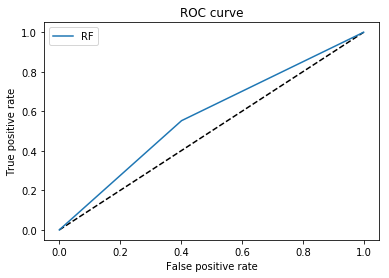

In [80]:
# MA cross side it decided
X = ma_side.values.reshape(-1,1)

# The meta-labeling on if we should take the bet or pass
y = labels.bin.values

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    shuffle=False)

# Create random forest model
n_estimator = 10
rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator)
# n_estimator = 10000
# rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator,
#                             criterion='entropy', random_state=123)
# fit the model
rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
# Make predictions
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

# Score our predictions
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [81]:
# 3.5
window = 500
num_std = 1
bol_df = pd.DataFrame().assign(price=close).assign(ma=close.rolling(window=window).mean())
std = close.rolling(window=window).std(ddof=0)
bol_df['high'] = bol_df.ma + num_std*std
bol_df['low'] = bol_df.ma - num_std*std

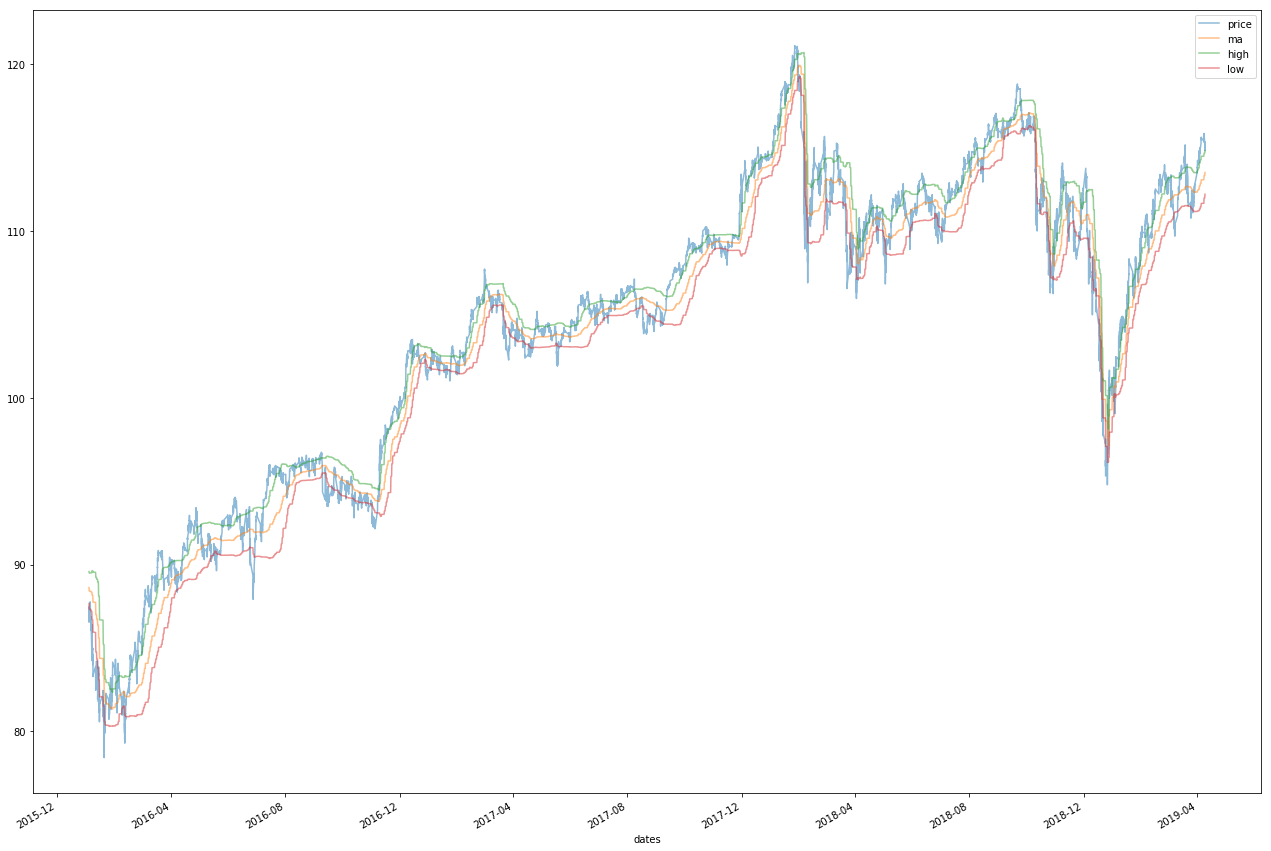

In [82]:
f, ax = plt.subplots(figsize=(22,16))
bol_df.loc['2016':].plot(ax=ax, alpha=.5)

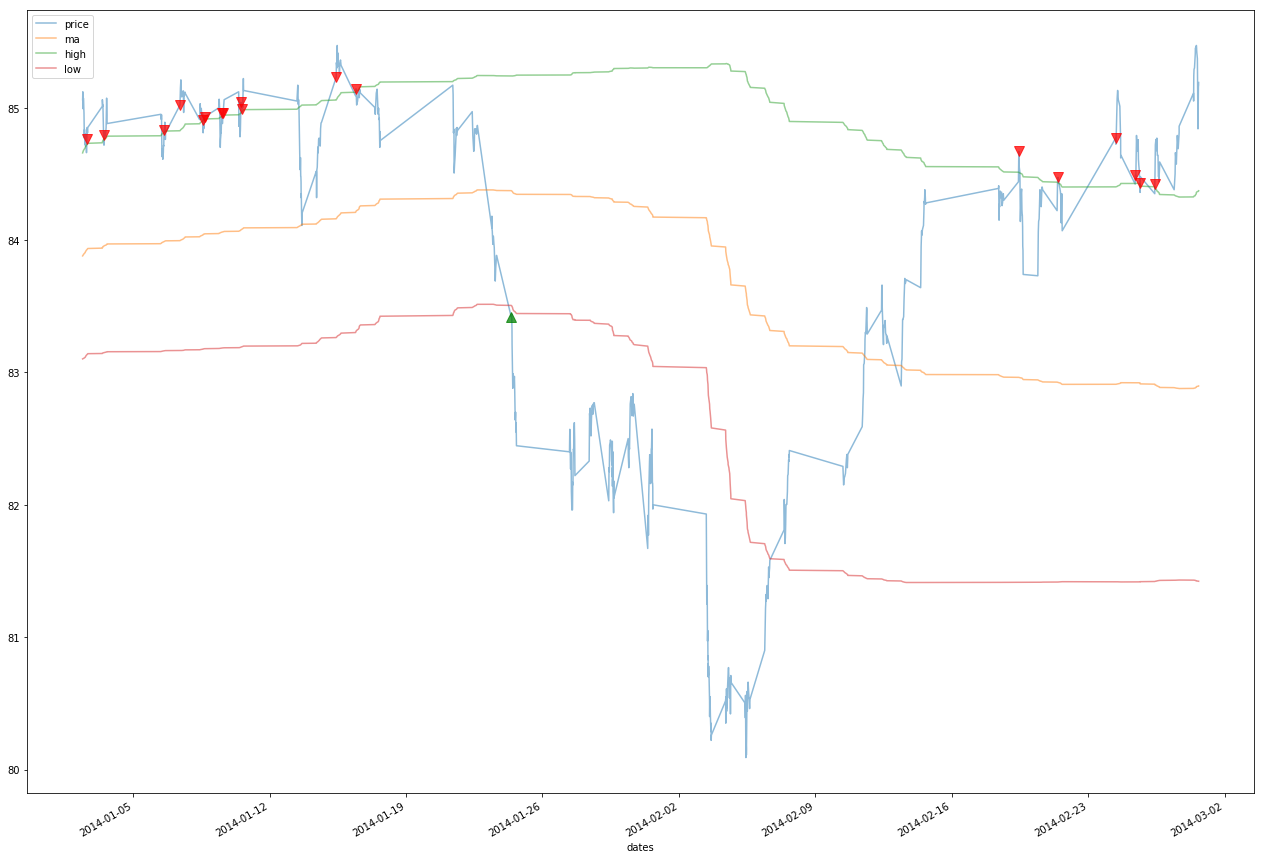

In [83]:
def buySignal(df):
    cross = df.price < df.low
    # Check if this is first time crossing
    first_cross = df.price.shift(1) > df.low.shift(1)
    return df.price[cross & first_cross]

def sellSignal(df):
    cross = df.price > df.high
    first_cross = df.price.shift(1) < df.high.shift(1)
    return df.price[cross & first_cross]
    
buy_sig = buySignal(bol_df)
sell_sig = sellSignal(bol_df)

f, ax = plt.subplots(figsize=(22,16))
bol_df.loc['2014-01':'2014-02'].plot(ax=ax, alpha=.5)
buy_sig.loc['2014-01':'2014-02'].plot(ax=ax,ls='',marker='^', markersize=10,
                     alpha=0.75, label='upcross', color='g')
sell_sig.loc['2014-01':'2014-02'].plot(ax=ax,ls='',marker='v', markersize=10, 
                       alpha=0.75, label='downcross', color='r')


In [84]:
long = pd.Series(1, index=buy_sig.index)
short = pd.Series(-1, index=sell_sig.index)
side = pd.concat([short, long]).sort_index()  # each time we switch sides

In [85]:
dailyVol = getDailyVol(bol_df.price)
tEvents = getTEvents(bol_df.price, h=dailyVol.mean())
t1 = addVerticalBarrier(tEvents, bol_df.price, 1)

minRet = 0.01
numThreads = 1
ptSl = [0, 2]
# Determine which barrier hit first
events = getEvents(bol_df.price, tEvents, ptSl, dailyVol, minRet, numThreads, t1=t1, side=side)

C:\Users\mlevy\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
C:\Users\mlevy\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


In [86]:
bol_side = events.dropna().side

In [87]:
bol_side.value_counts()

 1.0    118
-1.0     83
Name: side, dtype: int64

In [88]:
# Label to take the bet or pass (1, 0)
# labels = getBins_v2(events, bol_df.price, t1).dropna()
# not going to use veritcal barrier
labels = getBins_v2(events, bol_df.price).dropna()
labels.bin.value_counts()

C:\Users\mlevy\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in sign


0.0    101
1.0    100
Name: bin, dtype: int64

In [89]:
# b
# serial corr
ret_arr = np.diff(np.log(bol_df.price))
ret_s = pd.Series(ret_arr, index=bol_df.price.index[1:])

In [90]:
s_corr = ret_s.rolling(window=window).corr(ret_s.shift(1)).dropna()

In [91]:
features = pd.DataFrame().assign(vol=events.trgt).assign(ma_side=ma_side).assign(s_corr=s_corr).drop_duplicates().dropna()

In [92]:
data_set = pd.merge_asof(features, labels[['bin']], left_index=True, right_index=True, 
                    direction='forward').dropna()

In [94]:
data_set.bin.value_counts()

0.0    268
1.0    264
Name: bin, dtype: int64

             precision    recall  f1-score   support

   no_trade       0.53      0.22      0.31       146
      trade       0.45      0.77      0.56       120

avg / total       0.49      0.47      0.43       266

0.46616541353383456


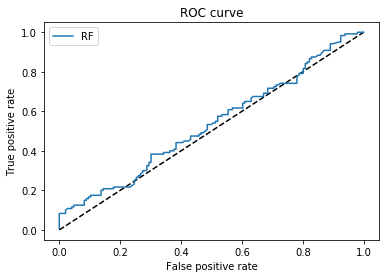

In [97]:
X = data_set.drop('bin', axis=1).values
y = data_set['bin'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    shuffle=False)

# Create random forest model
n_estimator = 1000
# default criterion is gini
# rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator)
# n_estimator = 10000
rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator,
                            criterion='entropy', random_state=123)
# fit the model
rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
# Make predictions
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

# Score our predictions
print(classification_report(y_test, y_pred, target_names=['no_trade','trade']))
print(accuracy_score(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [96]:
y_train

array([1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [98]:
# c

# No side provided this time
events = getEvents(bol_df.price, tEvents, ptSl, dailyVol, minRet, numThreads, t1=t1)
labels = getBins_v2(events, bol_df.price).dropna()

C:\Users\mlevy\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


             precision    recall  f1-score   support

   no_trade       0.59      0.35      0.44       116
      trade       0.62      0.81      0.70       150

avg / total       0.60      0.61      0.59       266

0.6090225563909775


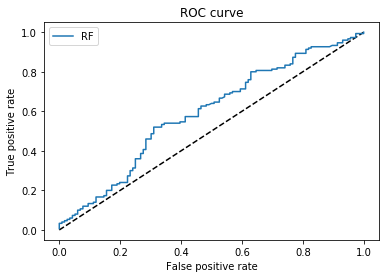

In [99]:
features = pd.DataFrame().assign(vol=events.trgt).assign(ma_side=ma_side).assign(s_corr=s_corr).drop_duplicates().dropna()
data_set = pd.merge_asof(features, labels[['bin']], left_index=True, right_index=True, 
                    direction='forward').dropna()
X = data_set.drop('bin', axis=1).values
y = data_set['bin'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    shuffle=False)

# Create random forest model
n_estimator = 1000
# default criterion is gini
# rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator)
# n_estimator = 10000
rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator,
                            criterion='entropy', random_state=123)
# fit the model
rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
# Make predictions
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

# Score our predictions
print(classification_report(y_test, y_pred, target_names=['no_trade','trade']))
print(accuracy_score(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()